In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

In [ ]:
import copy
import os
from time import time

from google_drive_downloader import GoogleDriveDownloader as gdd
from skimage.io import imread
from skimage.transform import resize
from tqdm.notebook import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rcParams["figure.figsize"] = (15, 8)

# Data preparation

In [ ]:
gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images, lesions = [], []

root = "PH2Dataset"

for root, dirs, files in os.walk(os.path.join(root, "PH2 Dataset images")):
    if root.endswith("_Dermoscopic_Image"):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith("_lesion"):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
size = (256, 256)

X = [
    resize(
        x,
        size,
        mode="constant",
        anti_aliasing=True,
    )
    for x in images
]
y = [resize(y, size, mode="constant", anti_aliasing=False) > 0.5 for y in lesions]

X = np.array(X, np.float32)
y = np.array(y, np.float32)

In [ ]:
idxs = np.random.permutation(len(X))
train_idxs, val_idxs, test_idxs = np.split(idxs, [100, 150])

X_train, y_train, = (
    X[train_idxs],
    y[train_idxs],
)
X_val, y_val = X[val_idxs], y[val_idxs]
X_test, y_test = X[test_idxs], y[test_idxs]

X_train, y_train = np.rollaxis(X_train, 3, 1), y_train[:, np.newaxis]
X_val, y_val = np.rollaxis(X_val, 3, 1), y_val[:, np.newaxis]
X_test, y_test = np.rollaxis(X_test, 3, 1), y_test[:, np.newaxis]

train_dataset = list(zip(X_train, y_train))
val_dataset = list(zip(X_val, y_val))
test_dataset = list(zip(X_test, y_test))

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

# ML preparation

## Metric

In [ ]:
def iou(tensor_1, tensor_2):
    tensor_1 = tensor_1.byte()
    tensor_2 = tensor_2.byte()

    intersection = (tensor_1 & tensor_2).sum((-1, -2))
    union = (tensor_1 | tensor_2).sum((-1, -2))

    iou = (intersection + 1e-8) / (union + 1e-8)

    iou_thresholded = torch.clamp(20 * (iou - 0.5), 0, 10) / 10

    return iou_thresholded

## Loss functions

In [ ]:
def bce_loss(y_logits, y_real):
    bce_loss = (y_logits.clamp(min=0) - y_logits * y_real + (1 + (-y_logits.abs()).exp()).log()).mean()

    return bce_loss

In [ ]:
def dice_loss(y_logits, y_real):
    y_pred = y_logits.sigmoid()

    intersection = (y_pred * y_real).sum()
    cardinality = y_pred.sum() + y_real.sum()

    dice_loss = (2 * (intersection + 1e-8) / (cardinality + 1e-8)).mean()

    return 1 - dice_loss

In [ ]:
def focal_loss(y_logits, y_real):
    y_pred = y_logits.sigmoid().clamp(1e-6, 1 - 1e-6)
    focal_loss = -(((1 - y_pred).pow(2) * y_real * y_pred.log() + (1 - y_real) * (1 - y_pred).log())).mean()

    return focal_loss

## Train functions

In [ ]:
def train_epoch(model, criterion, optimizer, train_loader):
    model.train()

    train_loss = 0
    train_acc = 0

    for X_batch, y_batch in tqdm(train_loader, leave=False, desc="train batch"):
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        y_logits = model(X_batch)
        y_pred = (y_logits > 0).float()

        loss = criterion(y_logits, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.detach().item()
        train_acc += iou(y_pred, y_batch).mean()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    return train_loss, train_acc

In [ ]:
def eval_epoch(model, criterion, val_loader):
    model.eval()

    val_loss = 0
    val_acc = 0

    for X_batch, y_batch in tqdm(val_loader, leave=False, desc="val batch"):
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        with torch.no_grad():
            y_logits = model(X_batch)
            y_pred = (y_logits > 0).float()

            loss = criterion(y_logits, y_batch)

        val_loss += loss.detach().item()
        val_acc += iou(y_pred, y_batch).mean()

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    return val_loss, val_acc

In [ ]:
def train(model, criterion, optimizer, train_dataset, val_dataset, epochs=20, batch=5, scheduler=None):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=True)

    for epoch in tqdm(range(epochs), leave=False, desc="epoch"):
        train_loss, train_acc = train_epoch(model, criterion, optimizer, train_loader)
        val_loss, val_acc = eval_epoch(model, criterion, val_loader)
        if scheduler:
            scheduler.step()
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        tqdm.write(f"Epoch {epoch + 1} train loss: {train_loss:.4f} val loss: {val_loss:.4f}")

    return {"train": train_losses, "val": val_losses}, {"train": train_accs, "val": val_accs}

## Inference

In [ ]:
def predict(model, data):
    model.eval()

    y_logits = torch.tensor([model(X_batch.to(DEVICE)) for X_batch in data])

    return y_logits

In [ ]:
def score_model(model):
    model.eval()

    score = torch.tensor([0.0]).to(DEVICE)

    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        y_logits = model(X_batch)
        y_pred = (y_logits > 0).float()

        score += iou(y_pred, y_batch).mean()

    score /= len(test_loader)

    return round(score.item(), 4)

In [ ]:
def visualize_model(model, dataset, num_images=5, binary=True):
    model.eval()

    data_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)

    X_batch, y_batch = next(iter(data_loader))

    X_batch = X_batch.to(DEVICE)
    y_batch = y_batch.to(DEVICE)

    y_pred = model(X_batch)
    if binary:
        y_pred = (y_pred > 0).float()

    fig, axes = plt.subplots(3, num_images)

    for i in range(num_images):
        axes[0][i].imshow(np.rollaxis(X_batch[i].cpu().numpy(), 0, 3))
        axes[0][i].axis("off")
        axes[0][i].set_title("image")
        axes[1][i].imshow(np.rollaxis(y_pred[i].detach().cpu().numpy(), 0, 3)[:, :, 0])
        axes[1][i].axis("off")
        axes[1][i].set_title("prediction")
        axes[2][i].imshow(np.rollaxis(y_batch[i].cpu().numpy(), 0, 3)[:, :, 0])
        axes[2][i].axis("off")
        axes[2][i].set_title("real")

    plt.show()

In [ ]:
def plot_loss(loss, model, config):
    for key in loss.keys():
        plt.plot(loss[key], "o-", label=key)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(model + " Loss")
    plt.legend(title=config)

    plt.show()

In [ ]:
def plot_acc(acc, model, config):
    for key in acc.keys():
        plt.plot(acc[key], "o-", label=key)
    plt.xlabel("epochs")
    plt.ylabel("iou")
    plt.title(model + " IOU")
    plt.legend(title=config)

    plt.show()

# Models

## SegNet

In [ ]:
class SegNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.enc_layer1 = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.enc_layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.enc_layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.enc_layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.enc_layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_layer1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_layer2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_layer3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, n_classes, kernel_size=3, padding=1),
        )

    def forward(self, x):
        e1, id1 = F.max_pool2d(self.enc_layer1(x), kernel_size=2, stride=2, return_indices=True)
        e2, id2 = F.max_pool2d(self.enc_layer2(e1), kernel_size=2, stride=2, return_indices=True)
        e3, id3 = F.max_pool2d(self.enc_layer3(e2), kernel_size=2, stride=2, return_indices=True)
        e4, id4 = F.max_pool2d(self.enc_layer4(e3), kernel_size=2, stride=2, return_indices=True)
        e5, id5 = F.max_pool2d(self.enc_layer5(e4), kernel_size=2, stride=2, return_indices=True)

        d1 = self.dec_layer1(F.max_unpool2d(e5, id5, kernel_size=2, stride=2))
        d2 = self.dec_layer2(F.max_unpool2d(d1, id4, kernel_size=2, stride=2))
        d3 = self.dec_layer3(F.max_unpool2d(d2, id3, kernel_size=2, stride=2))
        d4 = self.dec_layer4(F.max_unpool2d(d3, id2, kernel_size=2, stride=2))
        d5 = self.dec_layer5(F.max_unpool2d(d4, id1, kernel_size=2, stride=2))

        return d5

### bce_loss

In [ ]:
segnet_bce = SegNet(3, 1).to(DEVICE)
loss_func = bce_loss
optim_func = optim.AdamW(segnet_bce.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optim_func, step_size=8, gamma=0.1)

In [ ]:
segnet_bce_loss, segnet_bce_acc = train(
    segnet_bce, loss_func, optim_func, train_dataset, val_dataset, epochs=24, scheduler=exp_lr_scheduler
)

epoch:   0%|          | 0/24 [00:00<?, ?it/s]

train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.5539 val loss: 0.6713


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.3842 val loss: 0.6761


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.2902 val loss: 0.3243


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.2968 val loss: 0.3595


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.2864 val loss: 0.2925


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.2560 val loss: 0.2300


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.2387 val loss: 0.2802


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.2332 val loss: 0.2070


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.2301 val loss: 0.1715


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.1648 val loss: 0.1718


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.1844 val loss: 0.1602


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.1608 val loss: 0.1562


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.1574 val loss: 0.1729


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.1447 val loss: 0.1608


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.1493 val loss: 0.1664


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.1369 val loss: 0.1757


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.1321 val loss: 0.1857


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.1548 val loss: 0.1704


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.1263 val loss: 0.1783


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.1542 val loss: 0.1726


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.1264 val loss: 0.1631


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.1483 val loss: 0.1791


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.1356 val loss: 0.1612


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.1320 val loss: 0.1814


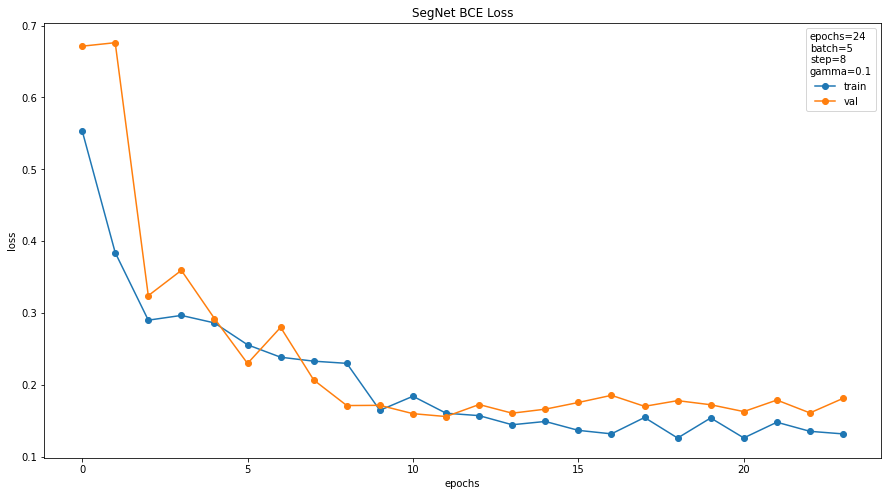

In [ ]:
plot_loss(segnet_bce_loss, "SegNet BCE", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

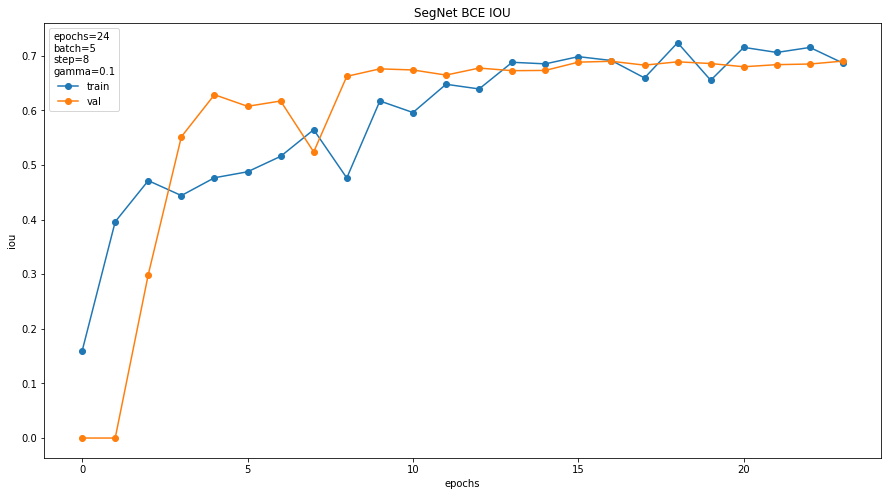

In [ ]:
plot_acc(segnet_bce_acc, "SegNet BCE", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

In [ ]:
score_model(segnet_bce)

0.7068

Оптимальными параметрами step и gamma оказались 8 и 0.1 соотвественно. При меньшем уменьшении learning rate лосс начинает сильно колебаться после 5 эпохи. При более быстром уменьшении лосс сходится к 0.2 и не может пойти ниже.

### dice_loss

In [ ]:
segnet_dice = SegNet(3, 1).to(DEVICE)
loss_func = dice_loss
optim_func = optim.AdamW(segnet_dice.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optim_func, step_size=8, gamma=0.1)

In [ ]:
segnet_dice_loss, segnet_dice_acc = train(
    segnet_dice, loss_func, optim_func, train_dataset, val_dataset, epochs=24, scheduler=exp_lr_scheduler
)

epoch:   0%|          | 0/24 [00:00<?, ?it/s]

train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.4603 val loss: 0.6483


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.2832 val loss: 0.4290


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.2259 val loss: 0.1745


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.2276 val loss: 0.1584


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.1942 val loss: 0.1547


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.1752 val loss: 0.1899


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.1693 val loss: 0.1768


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.1926 val loss: 0.1388


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.1262 val loss: 0.1321


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.1432 val loss: 0.1230


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.1422 val loss: 0.1246


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.1245 val loss: 0.1189


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.1496 val loss: 0.1271


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.1232 val loss: 0.1131


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.1215 val loss: 0.1215


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.1455 val loss: 0.1130


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.1127 val loss: 0.1096


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.1035 val loss: 0.1090


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.1209 val loss: 0.1106


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.1165 val loss: 0.1110


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.1185 val loss: 0.1156


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.1066 val loss: 0.1038


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.1118 val loss: 0.1092


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.0957 val loss: 0.1178


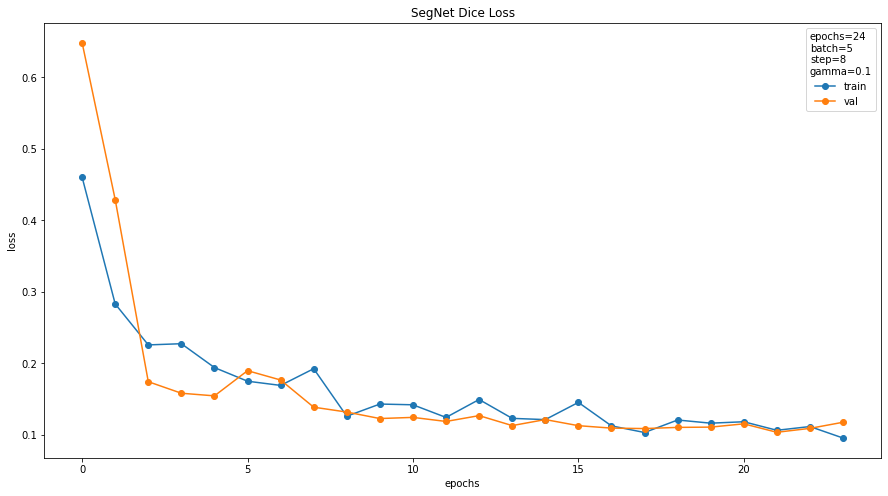

In [ ]:
plot_loss(segnet_dice_loss, "SegNet Dice", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

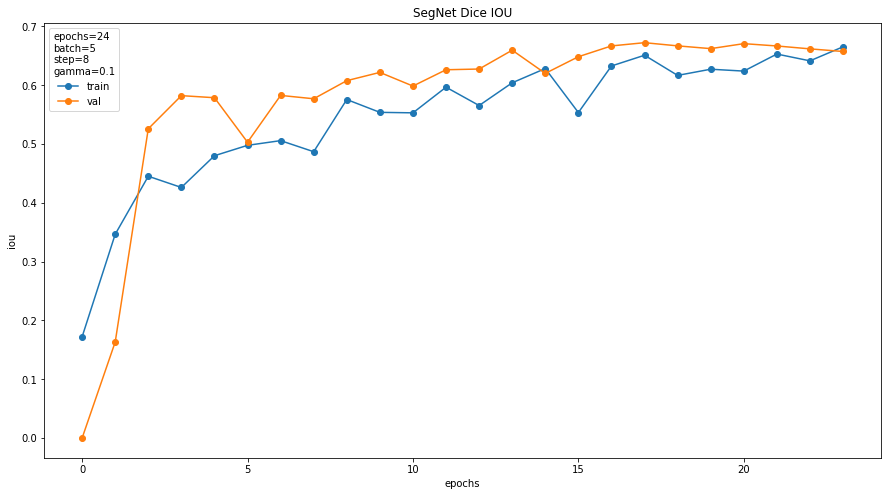

In [ ]:
plot_acc(segnet_dice_acc, "SegNet Dice", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

In [ ]:
score_model(segnet_dice)

0.6602

### focal_loss

In [ ]:
segnet_focal = SegNet(3, 1).to(DEVICE)
loss_func = focal_loss
optim_func = optim.AdamW(segnet_focal.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optim_func, step_size=8, gamma=0.1)

In [ ]:
segnet_focal_loss, segnet_focal_acc = train(
    segnet_focal, loss_func, optim_func, train_dataset, val_dataset, epochs=24, scheduler=exp_lr_scheduler
)

epoch:   0%|          | 0/24 [00:00<?, ?it/s]

train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.4122 val loss: 0.4668


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.2945 val loss: 0.4116


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.2602 val loss: 0.2152


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.2148 val loss: 0.2006


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.1737 val loss: 0.2122


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.1719 val loss: 0.1923


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.2030 val loss: 0.1746


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.1835 val loss: 0.1582


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.1687 val loss: 0.1466


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.1615 val loss: 0.1318


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.1619 val loss: 0.1317


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.1416 val loss: 0.1385


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.1514 val loss: 0.1305


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.1482 val loss: 0.1334


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.1285 val loss: 0.1356


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.1338 val loss: 0.1371


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.1128 val loss: 0.1425


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.1162 val loss: 0.1360


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.1233 val loss: 0.1442


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.1279 val loss: 0.1423


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.1137 val loss: 0.1495


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.1284 val loss: 0.1548


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.1343 val loss: 0.1457


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.1197 val loss: 0.1545


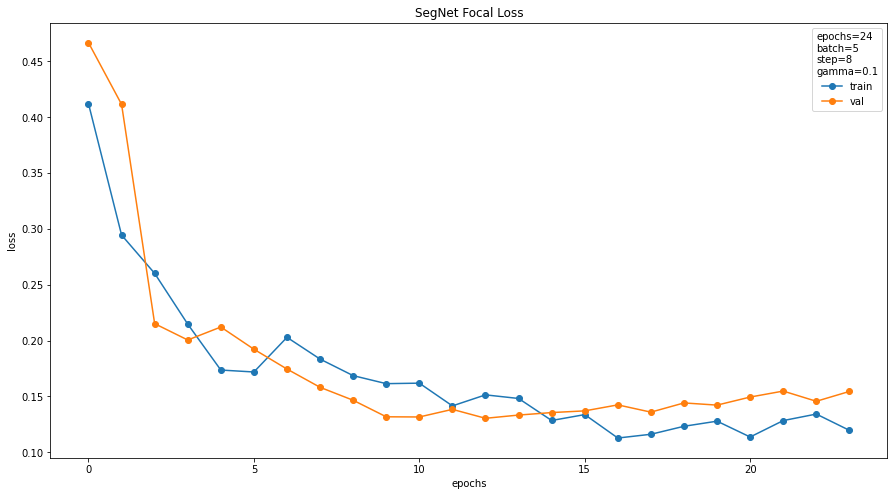

In [ ]:
plot_loss(segnet_focal_loss, "SegNet Focal", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

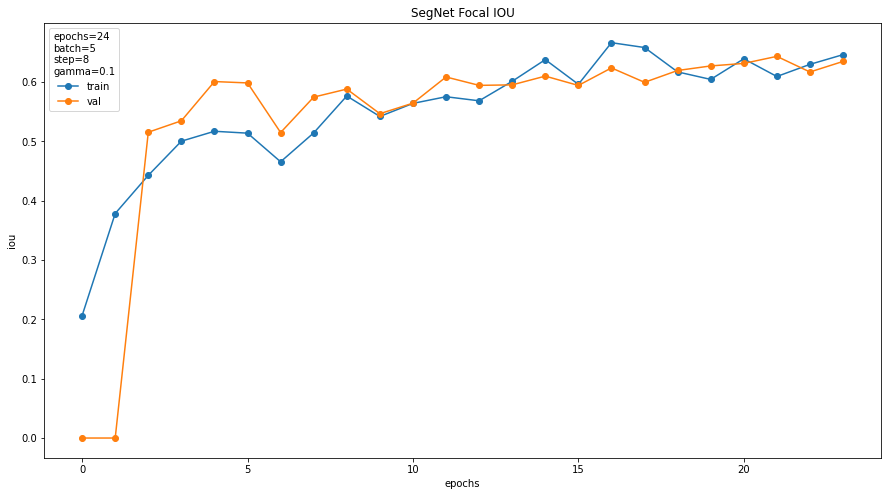

In [ ]:
plot_acc(segnet_focal_acc, "SegNet Focal", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

In [ ]:
score_model(segnet_focal)

0.6395

### Comparison

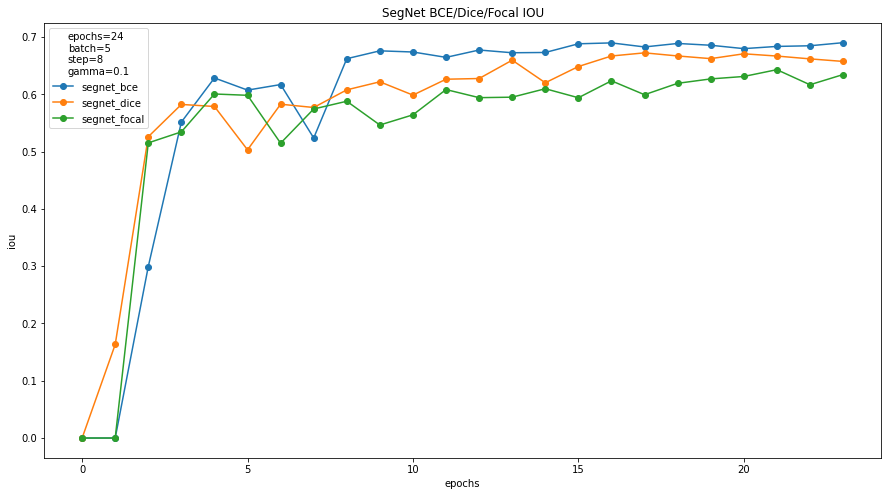

In [ ]:
segnet_acc = {
    "segnet bce": segnet_bce_acc["val"],
    "segnet dice": segnet_dice_acc["val"],
    "segnet focal": segnet_focal_acc["val"],
}
plot_acc(segnet_acc, "SegNet BCE/Dice/Focal", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

Можем видеть, что лучше всего показал себя BCE loss. Это, конечно, странно, возможно надо было больше модели обучать и посмотреть. 

## U-Net v1

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(nn.MaxPool2d(kernel_size=2), DoubleConv(in_channels, out_channels))

    def forward(self, x):
        return self.encoder(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsampler = nn.Upsample(scale_factor=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.upsampler(x1)
        dx = x2.shape[3] - x1.shape[3]
        dy = x2.shape[2] - x1.shape[2]
        x1 = F.pad(x1, (dx // 2, dx - dx // 2, dy // 2, dy - dy // 2))
        x = torch.cat([x1, x2], dim=1)
        return self.conv(x)

In [ ]:
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.out(x)

In [ ]:
class UNetV1(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.enc_layer1 = DoubleConv(n_channels, 64)
        self.enc_layer2 = Encoder(64, 128)
        self.enc_layer3 = Encoder(128, 256)
        self.enc_layer4 = Encoder(256, 512)

        self.bottleneck = Encoder(512, 512)

        self.dec_layer1 = Decoder(1024, 256)
        self.dec_layer2 = Decoder(512, 128)
        self.dec_layer3 = Decoder(256, 64)
        self.dec_layer4 = Decoder(128, 64)

        self.out = Out(64, n_classes)

    def forward(self, x):
        e1 = self.enc_layer1(x)
        e2 = self.enc_layer2(e1)
        e3 = self.enc_layer3(e2)
        e4 = self.enc_layer4(e3)

        b = self.bottleneck(e4)

        d1 = self.dec_layer1(b, e4)
        d2 = self.dec_layer2(d1, e3)
        d3 = self.dec_layer3(d2, e2)
        d4 = self.dec_layer4(d3, e1)

        logits = self.out(d4)

        return logits

### bce_loss

In [ ]:
unet_v1_bce = UNetV1(3, 1).to(DEVICE)
loss_func = bce_loss
optim_func = optim.AdamW(unet_v1_bce.parameters(), lr=1e-4)

In [ ]:
unet_v1_bce_loss, unet_v1_bce_acc = train(unet_v1_bce, loss_func, optim_func, train_dataset, val_dataset, epochs=20)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.4246 val loss: 0.6010


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.3239 val loss: 0.3911


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.2980 val loss: 0.2678


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.2578 val loss: 0.2857


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.2486 val loss: 0.2572


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.2447 val loss: 0.2198


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.2557 val loss: 0.2144


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.2128 val loss: 0.2010


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.2125 val loss: 0.2514


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.2479 val loss: 0.2652


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.1953 val loss: 0.2460


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.2440 val loss: 0.2319


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.2194 val loss: 0.2492


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.1932 val loss: 0.2195


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.1887 val loss: 0.2124


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.1796 val loss: 0.2014


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.1988 val loss: 0.1876


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.1912 val loss: 0.2059


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.2125 val loss: 0.1814


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.1891 val loss: 0.1835


In [ ]:
unet_v1_bce_loss_1, unet_v1_bce_acc_1 = train(unet_v1_bce, loss_func, optim_func, train_dataset, val_dataset, epochs=10)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.1511 val loss: 0.1641


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.1377 val loss: 0.1500


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.1569 val loss: 0.1780


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.1312 val loss: 0.1645


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.1241 val loss: 0.1893


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.1545 val loss: 0.1868


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.1271 val loss: 0.2258


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.1220 val loss: 0.2203


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.1087 val loss: 0.1621


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.1147 val loss: 0.1706


In [ ]:
unet_v1_bce_loss["train"] += unet_v1_bce_loss_1["train"]
unet_v1_bce_loss["val"] += unet_v1_bce_loss_1["val"]
unet_v1_bce_acc["train"] += unet_v1_bce_acc_1["train"]
unet_v1_bce_acc["val"] += unet_v1_bce_acc_1["val"]

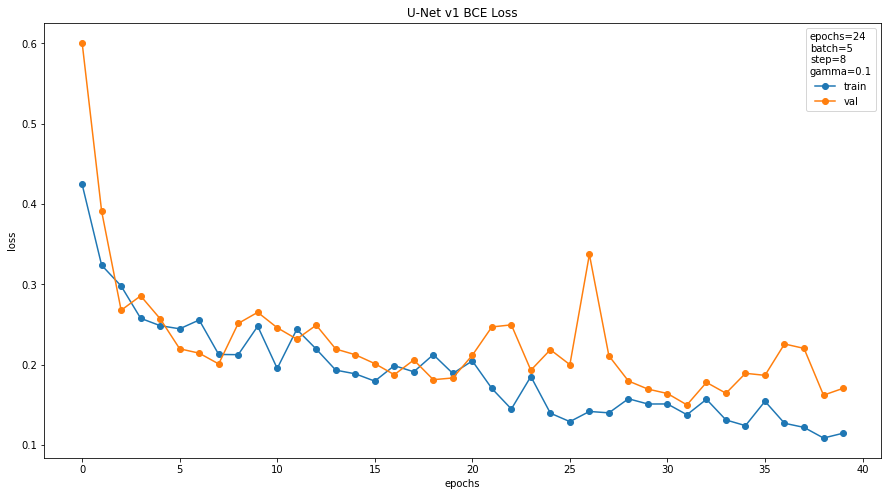

In [ ]:
plot_loss(unet_v1_bce_loss, "U-Net v1 BCE", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

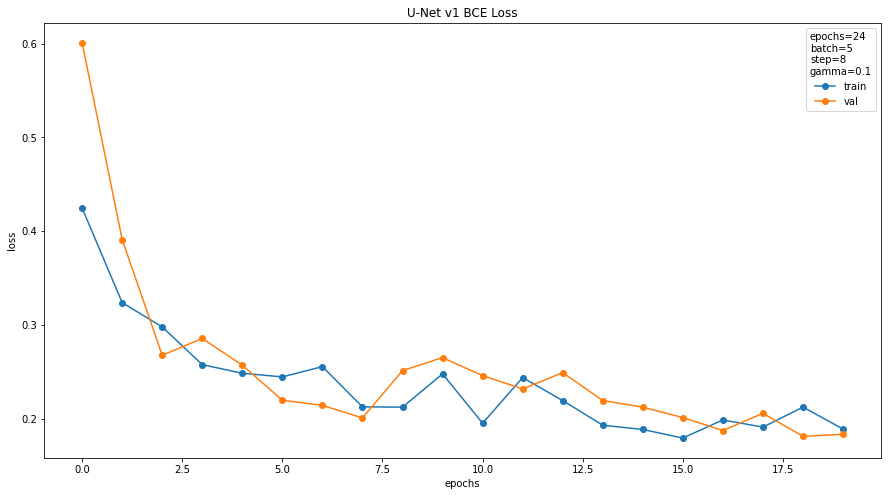

In [ ]:
plot_loss(unet_v1_bce_loss, "U-Net v1 BCE", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

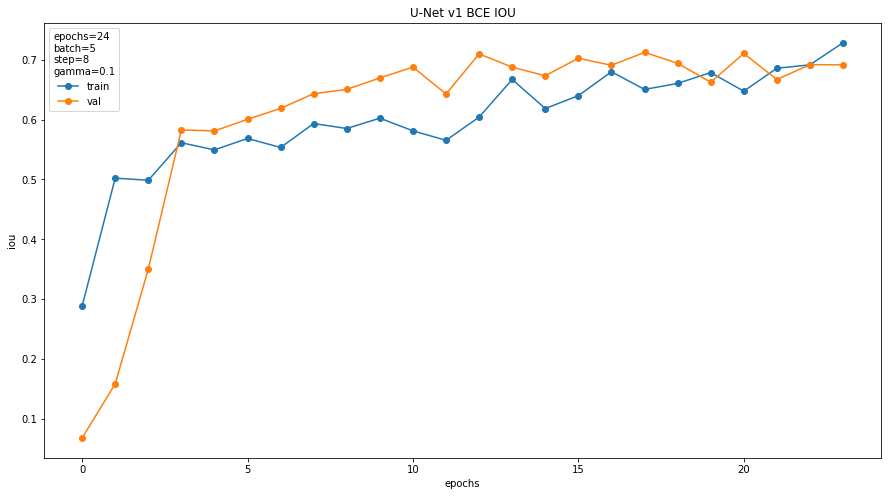

In [ ]:
plot_acc(unet_v1_bce_acc, "U-Net v1 BCE", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

In [ ]:
score_model(unet_v1_bce)

0.6989

### dice_loss

In [ ]:
unet_v1_dice = UNetV1(3, 1).to(DEVICE)
loss_func = dice_loss
optim_func = optim.AdamW(unet_v1_dice.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optim_func, step_size=8, gamma=0.1)

In [ ]:
unet_v1_dice_loss, unet_v1_dice_acc = train(
    unet_v1_dice, loss_func, optim_func, train_dataset, val_dataset, epochs=24, scheduler=exp_lr_scheduler
)

epoch:   0%|          | 0/24 [00:00<?, ?it/s]

train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.3703 val loss: 0.6575


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.2519 val loss: 0.3370


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.2539 val loss: 0.2311


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.1961 val loss: 0.1663


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.2065 val loss: 0.1575


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.1863 val loss: 0.1722


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.1633 val loss: 0.1680


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.1845 val loss: 0.1398


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.1861 val loss: 0.1576


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.1314 val loss: 0.1603


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.1473 val loss: 0.1549


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.1316 val loss: 0.1578


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.1497 val loss: 0.1389


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.1264 val loss: 0.1394


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.1333 val loss: 0.1343


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.1420 val loss: 0.1499


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.1569 val loss: 0.1472


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.1544 val loss: 0.1534


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.1479 val loss: 0.1385


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.1424 val loss: 0.1384


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.1285 val loss: 0.1418


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.1221 val loss: 0.1307


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.1182 val loss: 0.1350


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.1333 val loss: 0.1385


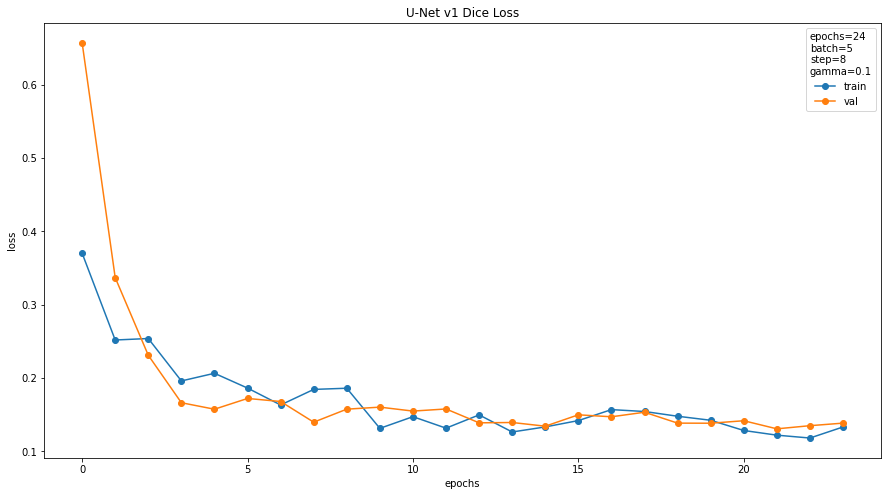

In [ ]:
plot_loss(unet_v1_dice_loss, "U-Net v1 Dice", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

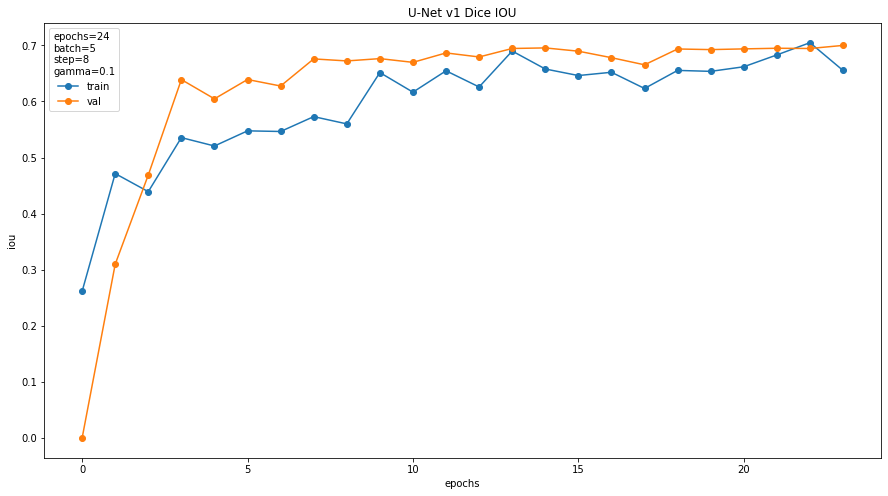

In [ ]:
plot_acc(unet_v1_dice_acc, "U-Net v1 Dice", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

In [ ]:
score_model(unet_v1_dice)

0.7169

### focal_loss

In [ ]:
unet_v1_focal = UNetV1(3, 1).to(DEVICE)
loss_func = focal_loss
optim_func = optim.AdamW(unet_v1_focal.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optim_func, step_size=8, gamma=0.1)

In [ ]:
unet_v1_focal_loss, unet_v1_focal_acc = train(
    unet_v1_focal, loss_func, optim_func, train_dataset, val_dataset, epochs=24, scheduler=exp_lr_scheduler
)

epoch:   0%|          | 0/24 [00:00<?, ?it/s]

train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.3526 val loss: 0.4260


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.2796 val loss: 0.2796


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.2231 val loss: 0.2561


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.2205 val loss: 0.2261


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.2043 val loss: 0.2082


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.1975 val loss: 0.2038


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.2060 val loss: 0.1704


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.1683 val loss: 0.1931


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.1797 val loss: 0.1608


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.1709 val loss: 0.1669


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.1610 val loss: 0.1573


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.1423 val loss: 0.1691


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.1607 val loss: 0.1806


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.1547 val loss: 0.1691


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.1474 val loss: 0.1787


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.1511 val loss: 0.1685


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.1357 val loss: 0.1581


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.1336 val loss: 0.1824


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.1422 val loss: 0.1599


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.1344 val loss: 0.1637


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.1537 val loss: 0.1667


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.1437 val loss: 0.1629


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.1288 val loss: 0.1651


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.1410 val loss: 0.1806


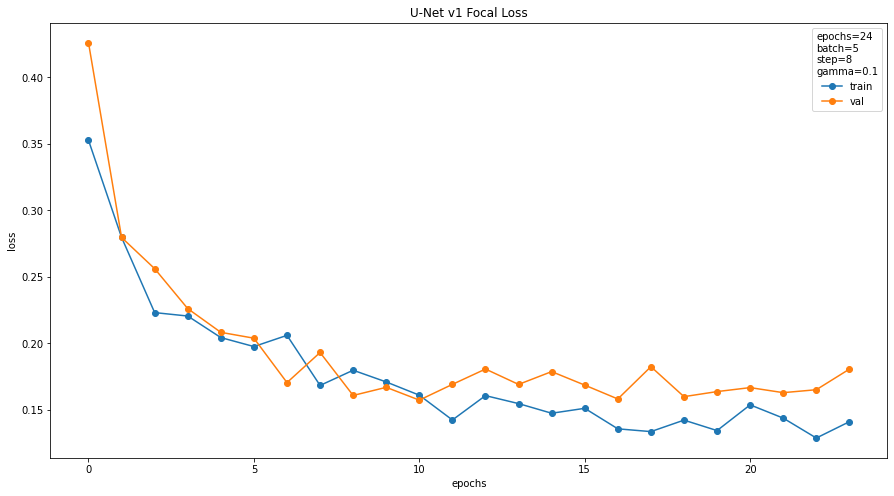

In [ ]:
plot_loss(unet_v1_focal_loss, "U-Net v1 Focal", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

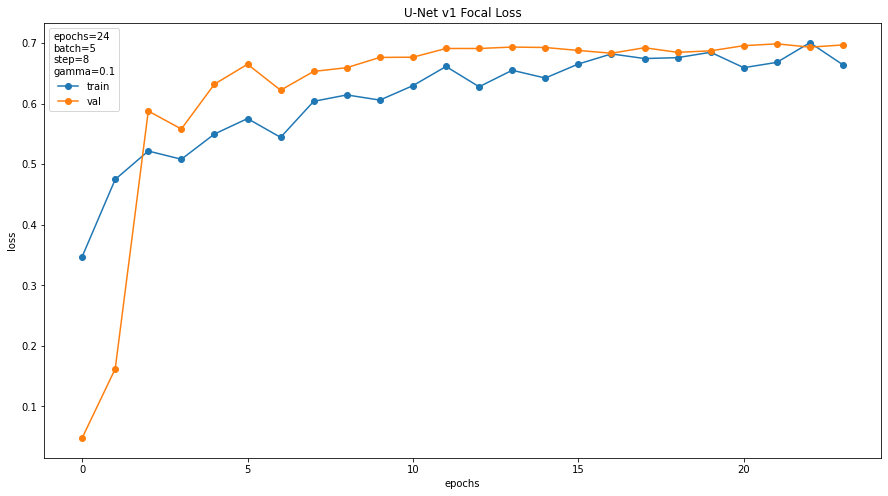

In [ ]:
plot_loss(unet_v1_focal_acc, "U-Net v1 Focal", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

In [ ]:
score_model(unet_v1_focal)

0.6868

### Comparison

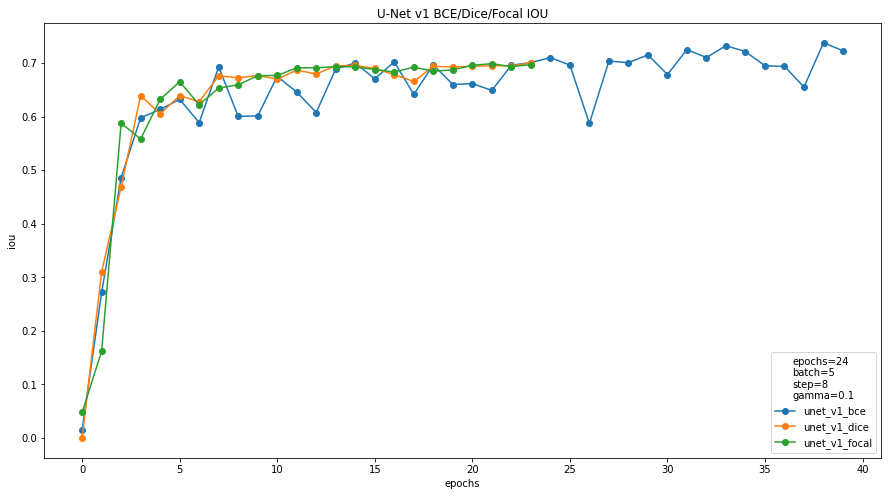

In [ ]:
unet_v1_acc = {
    "unet_v1_bce": unet_v1_bce_acc["val"],
    "unet_v1_dice": unet_v1_dice_acc["val"],
    "unet_v1_focal": unet_v1_focal_acc["val"],
}
plot_acc(unet_v1_acc, "U-Net v1 BCE/Dice/Focal", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

Видно, что модели с dice и focal loss более стабильны в свих предсказаниях, нежели чем модель с bce loss. В целом они +- дают одинаковые результаты на обучающем датасете, однако, на тестовом датасете модель с dice loss выигрывает.

## U-Net v2

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.encoder(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsampler = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=3, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.upsampler(x1)
        dx = x2.shape[3] - x1.shape[3]
        dy = x2.shape[2] - x1.shape[2]
        x1 = F.pad(x1, (dx // 2, dx - dx // 2, dy // 2, dy - dy // 2))
        x = torch.cat([x1, x2], dim=1)
        return self.conv(x)

In [ ]:
class UNetV2(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.enc_layer1 = DoubleConv(n_channels, 64)
        self.enc_layer2 = Encoder(64, 128)
        self.enc_layer3 = Encoder(128, 256)
        self.enc_layer4 = Encoder(256, 512)

        self.bottleneck = Encoder(512, 512)

        self.dec_layer1 = Decoder(1024, 256)
        self.dec_layer2 = Decoder(512, 128)
        self.dec_layer3 = Decoder(256, 64)
        self.dec_layer4 = Decoder(128, 64)
        self.out = Out(64, n_classes)

    def forward(self, x):
        e1 = self.enc_layer1(x)
        e2 = self.enc_layer2(e1)
        e3 = self.enc_layer3(e2)
        e4 = self.enc_layer4(e3)

        b = self.bottleneck(e4)

        d1 = self.dec_layer1(b, e4)
        d2 = self.dec_layer2(d1, e3)
        d3 = self.dec_layer3(d2, e2)
        d4 = self.dec_layer4(d3, e1)

        logits = self.out(d4)

        return logits

### bce_loss

In [ ]:
unet_v2_bce = UNetV2(3, 1).to(DEVICE)
loss_func = bce_loss
optim_func = optim.AdamW(unet_v2_bce.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optim_func, step_size=8, gamma=0.1)

In [ ]:
unet_v2_bce_loss, unet_v2_bce_acc = train(
    unet_v2_bce, loss_func, optim_func, train_dataset, val_dataset, epochs=24, scheduler=exp_lr_scheduler
)

epoch:   0%|          | 0/24 [00:00<?, ?it/s]

train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.4057 val loss: 0.6068


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.3109 val loss: 0.4772


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.2947 val loss: 0.3169


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.2466 val loss: 0.2697


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.2596 val loss: 0.3740


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.2364 val loss: 0.2568


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.2352 val loss: 0.2831


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.2372 val loss: 0.2137


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.2230 val loss: 0.2092


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.2086 val loss: 0.2300


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.1992 val loss: 0.2247


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.1667 val loss: 0.1984


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.1841 val loss: 0.2020


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.1810 val loss: 0.2203


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.1875 val loss: 0.2320


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.1990 val loss: 0.2002


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.1863 val loss: 0.2091


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.1615 val loss: 0.2003


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.1557 val loss: 0.1961


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.1900 val loss: 0.1899


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.1602 val loss: 0.2121


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.1614 val loss: 0.1989


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.1676 val loss: 0.1737


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.1789 val loss: 0.1970


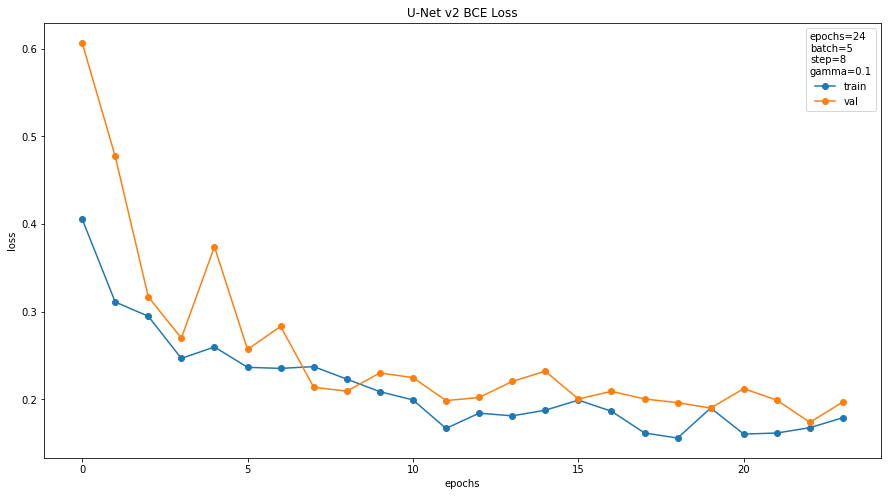

In [ ]:
plot_loss(unet_v2_bce_loss, "U-Net v2 BCE", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

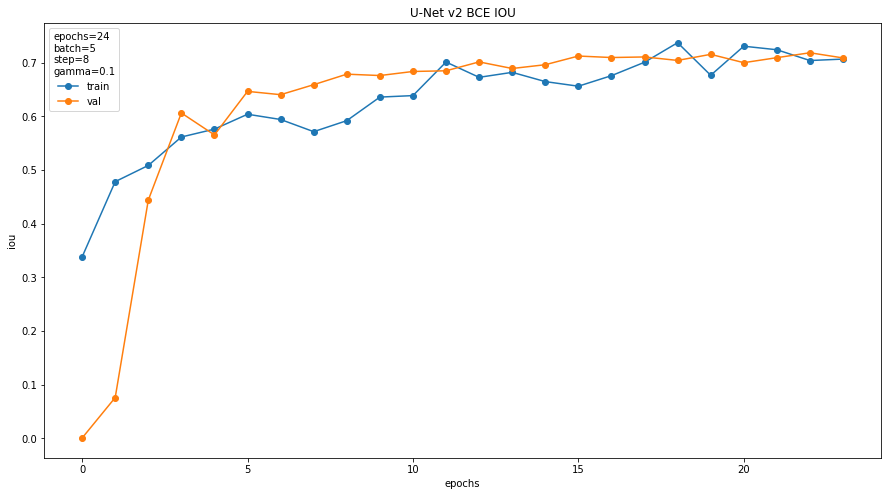

In [ ]:
plot_acc(unet_v2_bce_acc, "U-Net v2 BCE", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

In [ ]:
score_model(unet_v2_bce)

0.7202

### dice_loss

In [ ]:
unet_v2_dice = UNet2(3, 1).to(DEVICE)
loss_func = dice_loss
optim_func = optim.AdamW(unet_v2_dice.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optim_func, step_size=8, gamma=0.1)

In [ ]:
unet_v2_dice_loss, unet_v2_dice_acc = train(
    unet_v2_dice, loss_func, optim_func, train_dataset, val_dataset, epochs=24, scheduler=exp_lr_scheduler
)

epoch:   0%|          | 0/24 [00:00<?, ?it/s]

train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.3497 val loss: 0.6857


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.2622 val loss: 0.3163


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.2519 val loss: 0.2242


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.2016 val loss: 0.1756


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.1969 val loss: 0.1594


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.1608 val loss: 0.1942


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.1845 val loss: 0.1629


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.1803 val loss: 0.1647


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.1662 val loss: 0.1458


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.1523 val loss: 0.1265


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.1450 val loss: 0.1518


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.1417 val loss: 0.1278


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.1395 val loss: 0.1186


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.1276 val loss: 0.1384


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.1491 val loss: 0.1246


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.1374 val loss: 0.1354


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.1423 val loss: 0.1362


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.1367 val loss: 0.1261


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.1337 val loss: 0.1339


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.1312 val loss: 0.1422


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.1456 val loss: 0.1299


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.1528 val loss: 0.1277


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.1406 val loss: 0.1245


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.1389 val loss: 0.1351


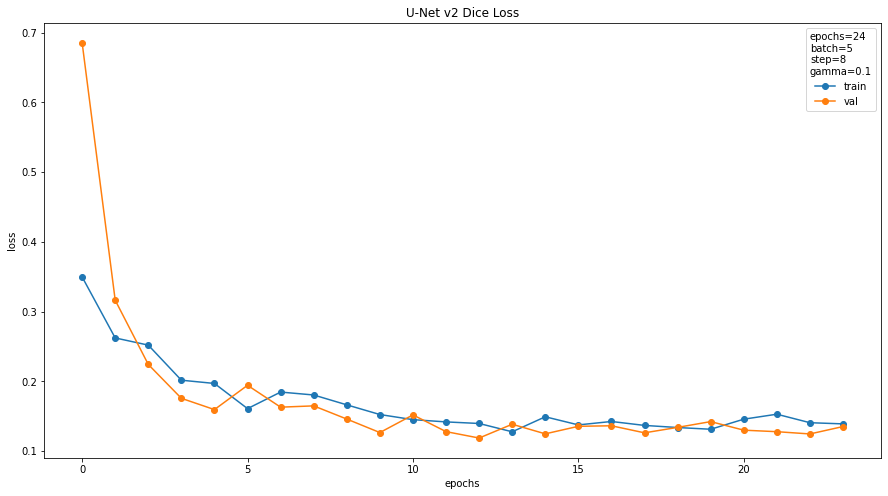

In [ ]:
plot_loss(unet_v2_dice_loss, "U-Net v2 Dice", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

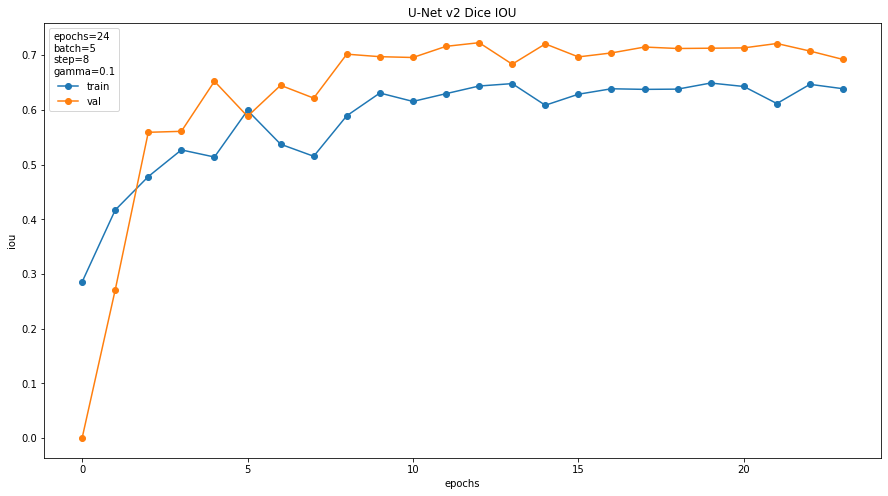

In [ ]:
plot_acc(unet_v2_dice_acc, "U-Net v2 Dice", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

In [ ]:
score_model(unet_v2_dice)

0.6538

### focal_loss

In [ ]:
unet_v2_focal = UNet2(3, 1).to(DEVICE)
loss_func = focal_loss
optim_func = optim.AdamW(unet_v2_focal.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optim_func, step_size=8, gamma=0.1)

In [ ]:
unet_v2_focal_loss, unet_v2_focal_acc = train(
    unet_v2_focal, loss_func, optim_func, train_dataset, val_dataset, epochs=24, scheduler=exp_lr_scheduler
)

epoch:   0%|          | 0/24 [00:00<?, ?it/s]

train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.3581 val loss: 0.4256


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.2738 val loss: 0.2797


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.2336 val loss: 0.2431


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.2271 val loss: 0.2523


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.2128 val loss: 0.2037


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.2187 val loss: 0.1848


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.1944 val loss: 0.2026


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.1770 val loss: 0.2192


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.1777 val loss: 0.1903


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.1565 val loss: 0.1577


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.1628 val loss: 0.1476


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.1487 val loss: 0.1453


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.1481 val loss: 0.1574


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.1523 val loss: 0.1792


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.1628 val loss: 0.1623


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.1387 val loss: 0.1505


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.1427 val loss: 0.1650


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.1220 val loss: 0.1638


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.1334 val loss: 0.1492


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.1362 val loss: 0.1549


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.1372 val loss: 0.1563


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.1406 val loss: 0.1486


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.1372 val loss: 0.1498


train batch:   0%|          | 0/20 [00:00<?, ?it/s]

val batch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.1493 val loss: 0.1460


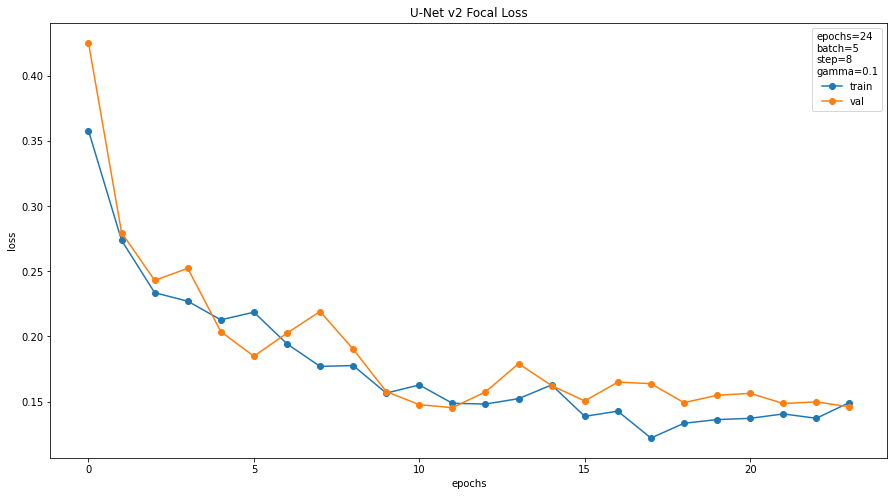

In [ ]:
plot_loss(unet_v2_focal_loss, "U-Net v2 Focal", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

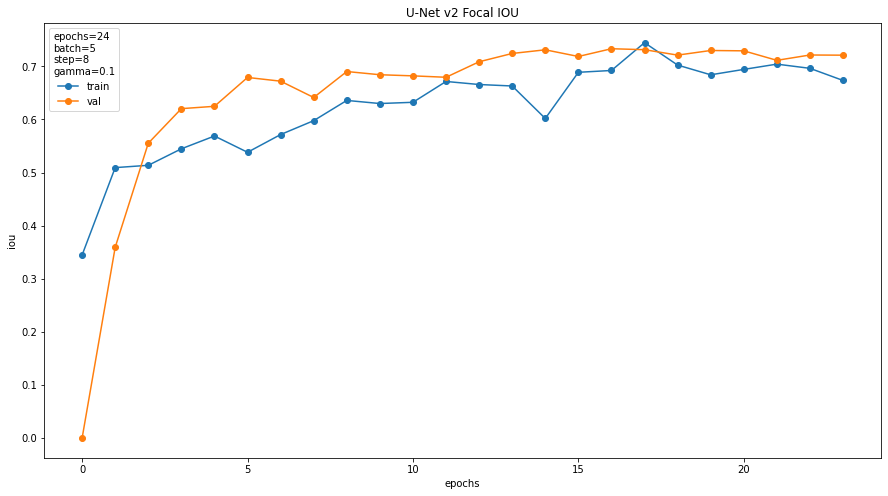

In [ ]:
plot_acc(unet_v2_focal_acc, "U-Net v2 Focal", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

In [ ]:
score_model(unet_v2_focal)

0.701

### Comparison 

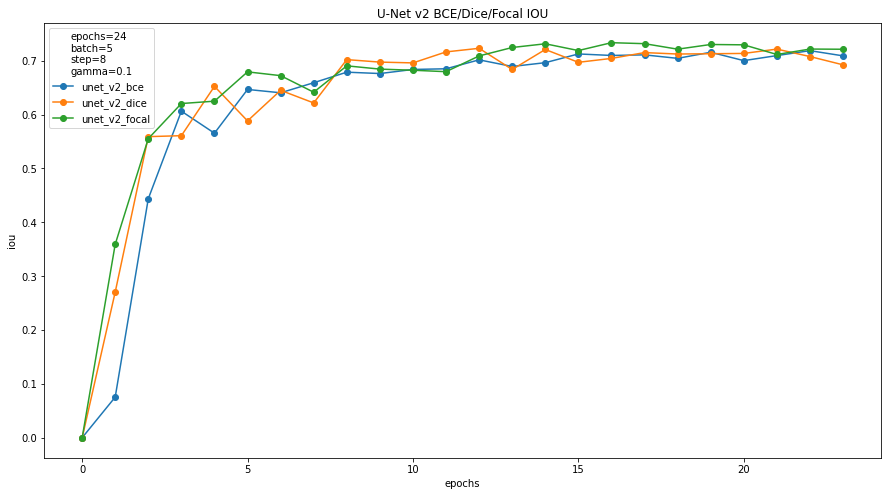

In [ ]:
unet_v2_acc = {
    "unet_v2_bce": unet_v2_bce_acc["val"],
    "unet_v2_dice": unet_v2_dice_acc["val"],
    "unet_v2_focal": unet_v2_focal_acc["val"],
}
plot_acc(unet_v2_acc, "U-Net v2 BCE/Dice/Focal", "epochs=24\nbatch=5\nstep=8\ngamma=0.1")

Видим, что на обучающей выборке модель с bce loss уступает двум другим моделям, но на тестовой она показала наивысший результат. Следовало бы провести больше обучений, чтобы исключить влияние случая в результаты. 

# Report

SegNet: BCE - 0.7068, Dice - 0.66, Focal - 0.64

U-Net v1: BCE - 0.6989, Dice - 0.7169, Focal - 0.6886

U-Net v2: BCE - 0.72, Dice - 0.654, Focal - 0.701

В результате обучения разных моделей можно видеть, что модели c bce loss показали более высокий результат на тестовой выборке, но на обучающей из графиков видно, что модели с bce лоссом не так стабильны, как другие. В целом, требуется больше изучения, чтобы сделать однозначные выводы.


